# Triple Barrier Labeling

## Setup

In [71]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (12, 2)
import seaborn as sns
sns.set(style="ticks", palette="tab10")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
df = pd.read_pickle('../data/resampled//USDJPY-15m-20210101-20241231.pkl')

In [73]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'spread'], dtype='object')

In [74]:
close = df['close']

<Axes: >

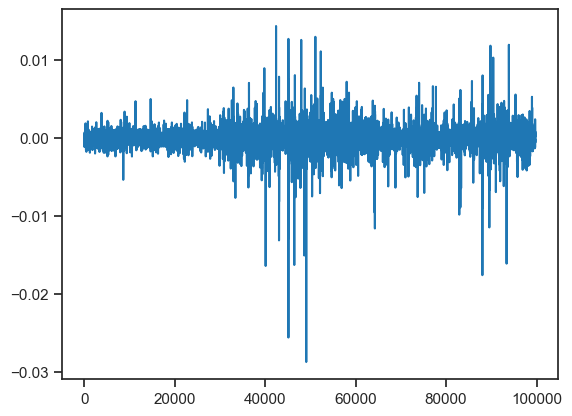

In [75]:
ret = np.log(close).diff().dropna()
ret.plot()

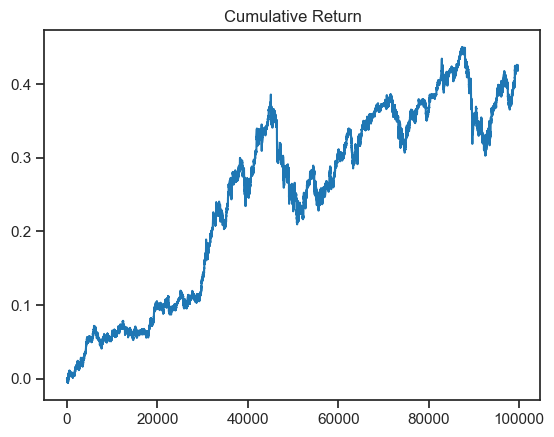

In [76]:
ret.cumsum().plot(title="Cumulative Return")
plt.show()

In [77]:
ret

1        0.000097
2       -0.000291
3        0.000131
4        0.000421
5        0.000281
           ...   
99719   -0.000175
99720    0.000831
99721    0.000041
99722    0.000041
99723   -0.000159
Name: close, Length: 99723, dtype: float64

In [78]:
def get_cumret(returns, n, center=True):
    df = pd.DataFrame(index=returns.index)
    for i in range(1, n + 1):
        df[i] = np.exp(returns.rolling(i).sum().shift(-i)) - 1
        if center:
            df[i] = df[i] - df[i].expanding().mean()
    return df

n = 80
cumret = get_cumret(ret, n, center=False)
cumret.head()

,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
1,-0.000291,-0.000160,0.000262,0.000542,0.000494,0.000097,-0.001056,-0.001211,-0.001855,-0.001681,...,-0.001153,-0.001017,-0.000673,-0.000475,-0.000867,-0.000988,-0.000998,-0.000605,-0.000925,-0.000964
2,0.000131,0.000552,0.000833,0.000785,0.000388,-0.000765,-0.000920,-0.001565,-0.001390,-0.001211,...,-0.000727,-0.000383,-0.000184,-0.000577,-0.000698,-0.000707,-0.000315,-0.000635,-0.000673,-0.000470
3,0.000421,0.000702,0.000654,0.000257,-0.000896,-0.001051,-0.001695,-0.001521,-0.001342,-0.001003,...,-0.000513,-0.000315,-0.000707,-0.000828,-0.000838,-0.000446,-0.000765,-0.000804,-0.000601,-0.000872
4,0.000281,0.000232,-0.000165,-0.001317,-0.001472,-0.002116,-0.001942,-0.001762,-0.001424,-0.001845,...,-0.000736,-0.001128,-0.001249,-0.001259,-0.000867,-0.001186,-0.001225,-0.001022,-0.001293,-0.001007
5,-0.000048,-0.000445,-0.001597,-0.001752,-0.002396,-0.002222,-0.002043,-0.001704,-0.002125,-0.002290,...,-0.001409,-0.001530,-0.001539,-0.001147,-0.001467,-0.001505,-0.001302,-0.001573,-0.001288,-0.001171


In [79]:
import pandas_ta as ta

trgt = df.ta.natr(length=n)/100
trgt = trgt.reindex_like(ret).fillna(999)
trgt

1        999.000000
2        999.000000
3        999.000000
4        999.000000
5        999.000000
            ...    
99719      0.000584
99720      0.000589
99721      0.000586
99722      0.000586
99723      0.000584
Name: NATR_80, Length: 99723, dtype: float64

In [80]:
pt_sl = [5,5]

In [81]:
upper_barrier = trgt * pt_sl[0]
lower_barrier = trgt * -pt_sl[1]

In [82]:
def check_dynamic_cross(cumret, barrier_up, barrier_down):
    up_cross = cumret.gt(barrier_up, axis=0)
    down_cross = cumret.lt(barrier_down, axis=0)

    # 找出最先觸發的位置
    first_up = up_cross.apply(lambda row: row.idxmax() if row.any() else np.nan, axis=1)
    first_down = down_cross.apply(lambda row: row.idxmax() if row.any() else np.nan, axis=1)

    # 建立 label: +1 (上突破), -1 (下突破), 0 (未突破)
    label = pd.Series(0, index=cumret.index)
    for i in cumret.index:
        if not np.isnan(first_up[i]) and (np.isnan(first_down[i]) or first_up[i] < first_down[i]):
            label[i] = 1
        elif not np.isnan(first_down[i]) and (np.isnan(first_up[i]) or first_down[i] < first_up[i]):
            label[i] = -1
    return label, first_up, first_down


In [83]:
label, first_up, first_down = check_dynamic_cross(cumret, upper_barrier, lower_barrier)

In [84]:
label.value_counts()

 1    37415
-1    31221
 0    31087
Name: count, dtype: int64